# Transformer (Ko-En) 번역기 v1.2
---
### 프로젝트 목표
한국어-영어 번역을 위한 트랜스포머 모델에 체크포인팅과 조기 종료 기능을 추가하여 학습 안정성 및 효율성을 개선

**주요 변경 사항 (v1.1 대비):**
1. **데이터 증강 방식 변경**: 사전 학습된 한국어 `ko.vec` 모델(`gensim` 활용)을 사용하여 Lexical Substitution을 수행 (v1.1 동일)
2. **Learning Rate Scheduler 적용**: 논문(All you need is Attention) 에서 제안된 스케줄러를 도입하여 학습을 안정화 (v1.1 동일)
3. **체크포인팅(Checkpointing)**: 훈련 중단 시 마지막으로 검증 성능이 좋았던 시점에서 훈련을 재개할 수 있도록 모델, 옵티마이저, 스케줄러 상태를 저장
4. **조기 종료(Early Stopping)**: 검증 손실(Validation Loss)이 일정 에폭(patience) 동안 개선되지 않으면 훈련을 조기 종료하여 불필요한 학습을 방지

## 1. 라이브러리 설치 및 임포트

In [1]:
!pip install sentencepiece
!pip install gensim
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 69.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 87.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 80.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/5 [numpy]
      Successfully uninstalled numpy-2.2.6━━━━━━━━━━━━━━━━━━━━━━━━ 1/5 [numpy]
  Attempting uninstall: scipy╺━━━━━━━━━━━━━━━━━━━━━━━ 2/5 [smart-open]
    Found existing installation: scipy 1.15.2━━━━━━━━━━━━━━━━━ 2/5 [smart-open]
    Uninstalling scipy-1.15.2:━━╺━━━━━━━━━━━━━━━ 3/5 [scipy]]
      Successfully uninstalled scipy-1.15.2━━━━━━━━━━━━━━━ 3/5 [scipy]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [gensim]2m4/5 [gensim]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.3 MB/s eta 0:00:00

In [2]:
import os
import re
import math
import time
import random
import locale

# 데이터 처리 및 연산
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# 자연어 처리(NLP) 및 머신러닝
import sentencepiece as spm
from gensim.models import KeyedVectors
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# 시각화 및 진행률 표시
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from tqdm.notebook import tqdm

In [3]:
def set_seed(seed):
    """모든 랜덤 시드를 고정하여 재현성을 보장합니다."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # for multi-GPU

# 사용할 시드 값 설정
SEED = 14
set_seed(SEED)

print(f"Random seed set to {SEED}")

Random seed set to 14


## 2. 하이퍼파라미터 및 설정

In [4]:
# Model Hyperparameters
SRC_VOCAB_SIZE = 20000
TGT_VOCAB_SIZE = 20000
D_MODEL = 512
N_LAYERS = 6
N_HEADS = 8
D_FF = 2048
DROPOUT = 0.1
MAX_LEN = 50

# Training Hyperparameters
BATCH_SIZE = 64
EPOCHS = 30
EARLY_STOPPING_PATIENCE = 3
CHECKPOINT_PATH = "transformer-1.2-checkpoint.pth"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 3. 데이터 준비 및 전처리

In [5]:
# 1. 데이터 경로 설정
data_dir = 'data'
train_kor_path = os.path.join(data_dir, 'korean-english-park.train.ko')
train_eng_path = os.path.join(data_dir, 'korean-english-park.train.en')
dev_kor_path = os.path.join(data_dir, 'korean-english-park.dev.ko')
dev_eng_path = os.path.join(data_dir, 'korean-english-park.dev.en')
test_kor_path = os.path.join(data_dir, 'korean-english-park.test.ko')
test_eng_path = os.path.join(data_dir, 'korean-english-park.test.en')

# 2. 원본 데이터 로딩
with open(train_kor_path, "r", encoding='utf-8') as f: train_kor_raw = f.read().splitlines()
with open(train_eng_path, "r", encoding='utf-8') as f: train_eng_raw = f.read().splitlines()
with open(dev_kor_path, "r", encoding='utf-8') as f: dev_kor_raw = f.read().splitlines()
with open(dev_eng_path, "r", encoding='utf-8') as f: dev_eng_raw = f.read().splitlines()
with open(test_kor_path, "r", encoding='utf-8') as f: test_kor_raw = f.read().splitlines()
with open(test_eng_path, "r", encoding='utf-8') as f: test_eng_raw = f.read().splitlines()

print(f"Train: {len(train_kor_raw)}, Dev: {len(dev_kor_raw)}, Test: {len(test_kor_raw)}")

Train: 94123, Dev: 1000, Test: 2000


In [6]:
# 3. 데이터 정제 및 전처리
def preprocess_sentence(sentence):
    """구두점, 특수문자 등 불필요한 부분을 제거하고 소문자로 변환합니다."""
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z가-힣?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

def clean_and_preprocess_corpus(kor_raw, eng_raw):
    """문장 쌍의 중복을 제거하고 각 문장을 전처리합니다."""
    # 1. zip으로 문장 쌍 생성 후 set으로 중복 제거
    cleaned_pairs = list(set(zip(kor_raw, eng_raw)))

    # 2. 각 문장 전처리
    kor_corpus, eng_corpus = [], []
    for kor, eng in cleaned_pairs:
        kor_corpus.append(preprocess_sentence(kor))
        eng_corpus.append(preprocess_sentence(eng))

    return kor_corpus, eng_corpus

# 각 데이터셋에 대해 정제 및 전처리 수행
train_kor_corpus, train_eng_corpus = clean_and_preprocess_corpus(train_kor_raw, train_eng_raw)
dev_kor_corpus, dev_eng_corpus = clean_and_preprocess_corpus(dev_kor_raw, dev_eng_raw)
test_kor_corpus, test_eng_corpus = clean_and_preprocess_corpus(test_kor_raw, test_eng_raw)

print(f"Train: {len(train_kor_corpus)}, Dev: {len(dev_kor_corpus)}, Test: {len(test_kor_corpus)}")

Train: 78968, Dev: 1000, Test: 1996


In [7]:
def generate_tokenizer(corpus, vocab_size, lang, pad_id=0, bos_id=1, eos_id=2, unk_id=3):
    file = f'./{lang}_corpus.txt'
    model_prefix = f'{lang}_spm'
    with open(file, 'w', encoding='utf-8') as f:
        for row in corpus:
            f.write(str(row) + '\n')
    spm.SentencePieceTrainer.Train(
        f'--input={file} --model_prefix={model_prefix} --vocab_size={vocab_size}' + 
        f' --pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} --unk_id={unk_id}'
    )
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'{model_prefix}.model')
    return tokenizer

ko_tokenizer = generate_tokenizer(train_kor_raw, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(train_eng_raw, TGT_VOCAB_SIZE, "en")

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=./ko_corpus.txt --model_prefix=ko_spm --vocab_size=20000 --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./ko_corpus.txt
  input_format: 
  model_prefix: ko_spm
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
 

## 4. 데이터셋 및 DataLoader 구축

In [8]:
class TranslationDataset(Dataset):
    def __init__(self, src_corpus, tgt_corpus, src_tokenizer, tgt_tokenizer):
        self.src_corpus = src_corpus
        self.tgt_corpus = tgt_corpus
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer

    def __len__(self):
        return len(self.src_corpus)

    def __getitem__(self, idx):
        src = self.src_tokenizer.encode_as_ids(self.src_corpus[idx])
        tgt = self.tgt_tokenizer.encode_as_ids(self.tgt_corpus[idx])

        # 텐서의 데이터 타입을 torch.long으로 명시적으로 지정합니다.
        return torch.tensor(src, dtype=torch.long), torch.tensor(tgt, dtype=torch.long)

def collate_fn(batch):
    """배치 내의 시퀀스들을 패딩하여 동일한 길이로 만듭니다."""
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(src_sample)
        tgt_batch.append(tgt_sample)

    src_padded = torch.nn.utils.rnn.pad_sequence(src_batch, batch_first=True, padding_value=ko_tokenizer.pad_id())
    tgt_padded = torch.nn.utils.rnn.pad_sequence(tgt_batch, batch_first=True, padding_value=en_tokenizer.pad_id())
    return src_padded, tgt_padded

# Dataset 및 DataLoader 인스턴스 생성
train_dataset = TranslationDataset(train_kor_corpus, train_eng_corpus, ko_tokenizer, en_tokenizer)
valid_dataset = TranslationDataset(dev_kor_corpus, dev_eng_corpus, ko_tokenizer, en_tokenizer)
test_dataset = TranslationDataset(test_kor_corpus, test_eng_corpus, ko_tokenizer, en_tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=4)

print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in valid_loader: {len(valid_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")

Number of batches in train_loader: 1234
Number of batches in valid_loader: 16
Number of batches in test_loader: 32


## 5. 데이터 증강 (Lexical Substitution)

In [9]:
# 1. 사전 학습된 한국어 Word2Vec 모델 로드 (.vec 텍스트 파일)
model_path = 'data/ko.vec' # .vec 파일 경로로 수정
print(f"Loading pre-trained Korean Word2Vec model from: {model_path}")
try:
    # .vec 파일은 텍스트 파일이므로 binary=False로 설정합니다.
    wv = KeyedVectors.load_word2vec_format(model_path, binary=False, unicode_errors='ignore')
    print("Model loaded successfully.")
except FileNotFoundError:
    print(f"ERROR: Model file not found at '{model_path}'. Please check the path.")
    wv = KeyedVectors(200)
except Exception as e:
    print(f"ERROR: Model file could not be loaded. Error: {e}")
    wv = KeyedVectors(200)


def augment_with_pretrained_wv(kor_corpus, eng_corpus, wv, num_augmented_sentences=40000):
    """
    사전 학습된 임베딩 모델(gensim KeyedVectors)을 사용한 Lexical Substitution으로 데이터를 증강합니다.
    """
    print("Starting data augmentation with pre-trained ko.vec model...")

    augmented_kor, augmented_eng = [], []
    original_indices = list(range(len(kor_corpus)))
    indices_to_augment = random.choices(original_indices, k=num_augmented_sentences)
    successful_augment_indices = []

    for sent_idx in tqdm(indices_to_augment, desc="Augmenting sentences"):
        original_sentence = kor_corpus[sent_idx]
        tokens = original_sentence.split()

        # gensim KeyedVectors 객체에 단어 포함 여부 확인
        valid_tokens = [tok for tok in tokens if tok in wv.key_to_index]

        if not valid_tokens:
            continue

        target_word = random.choice(valid_tokens)

        try:
            similar_words = wv.most_similar(target_word, topn=5)
            synonym = random.choice(similar_words)[0]
            new_kor_sentence = " ".join([synonym if tok == target_word else tok for tok in tokens])

            augmented_kor.append(new_kor_sentence)
            augmented_eng.append(eng_corpus[sent_idx])
            successful_augment_indices.append(sent_idx)

        except (KeyError, IndexError):
            continue

    print(f"Augmentation complete. {len(augmented_kor)} sentences generated.")
    return augmented_kor, augmented_eng, successful_augment_indices

# 데이터 증강 실행 (40,000개)
augmented_kor_corpus, augmented_eng_corpus, augmented_indices = augment_with_pretrained_wv(
    train_kor_corpus, train_eng_corpus, wv, num_augmented_sentences=40000
    )

# --- 증강 샘플 출력 ---
print("\n--- Augmentation Samples (with ko.vec Model) ---")
num_samples_to_print = 5
if not augmented_kor_corpus:
    print("No sentences were successfully augmented.")
else:
    for i in range(min(num_samples_to_print, len(augmented_kor_corpus))):
        original_idx = augmented_indices[i]
        print(f"Sample {i+1}:")
        print(f'  - Original KO:    {train_kor_corpus[original_idx]}')
        print(f'  - Augmented KO:   {augmented_kor_corpus[i]}')
        print(f'  - Corresponding EN: {train_eng_corpus[original_idx]}')
# --- 샘플 출력 끝 ---

# 기존 훈련 데이터에 증강된 데이터 추가
train_kor_corpus.extend(augmented_kor_corpus)
train_eng_corpus.extend(augmented_eng_corpus)

print(f'\nTotal training sentences after augmentation: {len(train_kor_corpus)}')

# 증강된 데이터로 데이터로더를 다시 만듭니다.
train_dataset = TranslationDataset(train_kor_corpus, train_eng_corpus, ko_tokenizer, en_tokenizer)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=4)

print("DataLoaders recreated with augmented data.")
print(f"Number of batches in new train_loader: {len(train_loader)}")

Loading pre-trained Korean Word2Vec model from: data/ko.vec
Model loaded successfully.
Starting data augmentation with pre-trained ko.vec model...


Augmenting sentences:   0%|          | 0/40000 [00:00<?, ?it/s]

Augmentation complete. 39433 sentences generated.

--- Augmentation Samples (with ko.vec Model) ---
Sample 1:
  - Original KO:    플레이스테이션 는 지난해 월 출시 이후 약 만개가 판매됐다 .
  - Augmented KO:   게임보이 는 지난해 월 출시 이후 약 만개가 판매됐다 .
  - Corresponding EN: sony has sold million playstation s since they went on sale in november last year .
Sample 2:
  - Original KO:    그는 주간 라디오 및 인터넷 성명을 통해 , 그의 , 억 달러 규모의 부양책으로 국가의 무너져 내리는 기반시설을 복구함으로써 수백만 명의 일자리를 창출하게 될 것이라고 말했습니다 .
  - Augmented KO:   그는 주간 라디오 관하 인터넷 성명을 통해 , 그의 , 억 달러 규모의 부양책으로 국가의 무너져 내리는 기반시설을 복구함으로써 수백만 명의 일자리를 창출하게 될 것이라고 말했습니다 .
  - Corresponding EN: in his weekly radio and internet address , the president says his billion recovery plan would put millions of people to work on repairing the country s crumbling infrastructure .
Sample 3:
  - Original KO:    kenyans burned to death in church 케냐 피난민들 , 폭도 방화로 교회에서 사망 .
  - Augmented KO:   kenyans burned to death in church 니제르 피난민들 , 폭도 방화로 교회에서 사망 .
  - Corresponding EN: this a much bigger figure 

## 6. 트랜스포머 모델 정의

In [10]:
class PositionalEncoding(nn.Module):
    """
    입력 임베딩에 위치 정보를 추가하는 클래스입니다.
    Transformer 모델은 순서 정보가 없으므로, 토큰의 위치를 알려주기 위해 sin/cos 함수를 사용합니다.
    이 방식은 고정 위치 인코딩으로, 학습되지 않는 파라미터(buffer)로 등록됩니다.
    """
    def __init__(self, emb_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        # sin/cos 함수에 사용할 div_term 계산: 주파수 조절을 위한 값
        div_term = torch.exp(torch.arange(0, emb_size, 2) * (-math.log(10000.0) / emb_size))
        # 각 위치(0~maxlen)에 대한 인덱스 생성
        position = torch.arange(maxlen).unsqueeze(1)
        # 위치 임베딩 행렬 초기화 (maxlen, emb_size)
        pos_embedding = torch.zeros(maxlen, emb_size)
        # 짝수 인덱스: sin 함수 적용
        pos_embedding[:, 0::2] = torch.sin(position * div_term)
        # 홀수 인덱스: cos 함수 적용
        pos_embedding[:, 1::2] = torch.cos(position * div_term)
        # 배치 차원 추가 (1, maxlen, emb_size)
        pos_embedding = pos_embedding.unsqueeze(0)
        self.dropout = nn.Dropout(dropout)
        # 학습되지 않는 파라미터로 등록
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding):
        """
        Args:
            token_embedding: (batch_size, seq_len, emb_size)
        Returns:
            token_embedding + pos_embedding: 위치 정보가 더해진 임베딩
        """
        return self.dropout(token_embedding + self.pos_embedding[:, :token_embedding.size(1), :])

class MultiHeadAttention(nn.Module):
    """
    다중 헤드 어텐션 메커니즘을 구현한 클래스.
    쿼리, 키, 값 행렬을 여러 헤드로 분할하여 병렬로 어텐션을 계산하고, 결과를 결합합니다.
    """
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // num_heads  # 각 헤드의 차원
        # 쿼리, 키, 값 행렬을 위한 선형 변환 레이어
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        # 최종 출력 선형 변환 레이어
        self.linear = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        """
        스케일드 닷-프로덕트 어텐션 계산.
        Args:
            Q: 쿼리 행렬
            K: 키 행렬
            V: 값 행렬
            mask: 어텐션 마스크 (선택적)
        Returns:
            out: 어텐션 가중치 적용된 값 행렬
            attentions: 어텐션 가중치 행렬
        """
        d_k = Q.size(-1)
        QK = torch.matmul(Q, K.transpose(-1, -2))  # QK^T 계산
        scaled_qk = QK / math.sqrt(d_k)  # 스케일링
        if mask is not None:
            scaled_qk += (mask * -1e9)  # 마스크 적용 (매우 작은 값 더하기)
        attentions = nn.Softmax(dim=-1)(scaled_qk)  # 소프트맥스 적용
        out = torch.matmul(attentions, V)  # 가중치 적용
        return out, attentions

    def split_heads(self, x):
        """
        입력 텐서를 여러 헤드로 분할.
        Args:
            x: (batch_size, seq_len, d_model)
        Returns:
            x: (batch_size, num_heads, seq_len, depth)
        """
        bsz, seq_len, _ = x.size()
        x = x.view(bsz, seq_len, self.num_heads, self.depth)
        return x.permute(0, 2, 1, 3)  # 차원 재배치

    def combine_heads(self, x):
        """
        분할된 헤드를 다시 결합.
        Args:
            x: (batch_size, num_heads, seq_len, depth)
        Returns:
            x: (batch_size, seq_len, d_model)
        """
        bsz, _, seq_len, _ = x.size()
        x = x.permute(0, 2, 1, 3).contiguous()
        return x.view(bsz, seq_len, self.d_model)

    def forward(self, Q, K, V, mask=None):
        """
        Args:
            Q: 쿼리 입력 (batch_size, seq_len, d_model)
            K: 키 입력
            V: 값 입력
            mask: 어텐션 마스크
        Returns:
            out: 어텐션 적용된 출력
            attention_weights: 어텐션 가중치
        """
        # 헤드 분할 후 어텐션 계산
        WQ = self.split_heads(self.W_q(Q))
        WK = self.split_heads(self.W_k(K))
        WV = self.split_heads(self.W_v(V))
        out, attention_weights = self.scaled_dot_product_attention(WQ, WK, WV, mask)
        # 헤드 결합 후 선형 변환
        out = self.combine_heads(out)
        out = self.linear(out)
        return out, attention_weights

class PoswiseFeedForwardNet(nn.Module):
    """
    포지션 와이즈 피드포워드 네트워크.
    각 위치별로 독립적으로 적용되는 2층 완전 연결 네트워크 (ReLU 활성화 함수 사용).
    """
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)  # 첫 번째 레이어 (차원 확장)
        self.fc2 = nn.Linear(d_ff, d_model)  # 두 번째 레이어 (원래 차원으로 복원)
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Args:
            x: (batch_size, seq_len, d_model)
        Returns:
            x: (batch_size, seq_len, d_model)
        """
        return self.fc2(self.relu(self.fc1(x)))

class EncoderLayer(nn.Module):
    """
    인코더의 단일 레이어.
    셀프 어텐션과 피드포워드 네트워크를 포함하며, 레이어 정규화와 드롭아웃을 적용합니다.
    """
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        self.norm_1 = nn.LayerNorm(d_model, eps=1e-6)  # 첫 번째 정규화
        self.norm_2 = nn.LayerNorm(d_model, eps=1e-6)  # 두 번째 정규화
        self.do = nn.Dropout(dropout)

    def forward(self, x, mask):
        """
        Args:
            x: 입력 텐서
            mask: 패딩 마스크
        Returns:
            out: 출력 텐서
            enc_attn: 셀프 어텐션 가중치
        """
        residual = x
        # 셀프 어텐션 + 드롭아웃 + 잔차 연결
        out, enc_attn = self.enc_self_attn(self.norm_1(x), self.norm_1(x), self.norm_1(x), mask)
        out = self.do(out) + residual
        residual = out
        # 피드포워드 네트워크 + 드롭아웃 + 잔차 연결
        out = self.ffn(self.norm_2(out))
        out = self.do(out) + residual
        return out, enc_attn

class DecoderLayer(nn.Module):
    """
    디코더의 단일 레이어.
    셀프 어텐션, 인코더-디코더 어텐션, 피드포워드 네트워크를 포함합니다.
    """
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)  # 셀프 어텐션
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)  # 인코더-디코더 어텐션
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        self.norm_1 = nn.LayerNorm(d_model, eps=1e-6)
        self.norm_2 = nn.LayerNorm(d_model, eps=1e-6)
        self.norm_3 = nn.LayerNorm(d_model, eps=1e-6)
        self.do = nn.Dropout(dropout)

    def forward(self, x, enc_out, dec_enc_mask, padding_mask):
        """
        Args:
            x: 디코더 입력
            enc_out: 인코더 출력
            dec_enc_mask: 디코더-인코더 어텐션 마스크
            padding_mask: 패딩 마스크
        Returns:
            out: 출력 텐서
            dec_attn: 셀프 어텐션 가중치
            dec_enc_attn: 인코더-디코더 어텐션 가중치
        """
        residual = x
        # 셀프 어텐션 (look-ahead 마스크 적용)
        out, dec_attn = self.dec_self_attn(self.norm_1(x), self.norm_1(x), self.norm_1(x), mask=padding_mask)
        out = self.do(out) + residual
        residual = out
        # 인코더-디코더 어텐션
        out, dec_enc_attn = self.enc_dec_attn(self.norm_2(out), enc_out, enc_out, mask=dec_enc_mask)
        out = self.do(out) + residual
        residual = out
        # 피드포워드 네트워크
        out = self.ffn(self.norm_3(out))
        out = self.do(out) + residual
        return out, dec_attn, dec_enc_attn

class Encoder(nn.Module):
    """
    인코더 전체 구조.
    임베딩 레이어, 위치 인코딩, 여러 개의 인코더 레이어로 구성됩니다.
    """
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout, vocab_size):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)  # 토큰 임베딩
        self.pos_encoding = PositionalEncoding(d_model, dropout)  # 위치 인코딩
        self.enc_layers = nn.ModuleList([EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])

    def forward(self, x, mask):
        """
        Args:
            x: 입력 시퀀스 (batch_size, seq_len)
            mask: 패딩 마스크
        Returns:
            out: 인코더 출력
            enc_attns: 각 레이어의 어텐션 가중치 리스트
        """
        out = self.embedding(x) * math.sqrt(self.d_model)  # 임베딩 스케일링
        out = self.pos_encoding(out)  # 위치 인코딩 추가
        enc_attns = []
        for layer in self.enc_layers:
            out, enc_attn = layer(out, mask)
            enc_attns.append(enc_attn)
        return out, enc_attns

class Decoder(nn.Module):
    """
    디코더 전체 구조.
    임베딩 레이어, 위치 인코딩, 여러 개의 디코더 레이어로 구성됩니다.
    """
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout, vocab_size):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, dropout)
        self.dec_layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])

    def forward(self, x, enc_out, dec_enc_mask, padding_mask):
        """
        Args:
            x: 디코더 입력 시퀀스
            enc_out: 인코더 출력
            dec_enc_mask: 디코더-인코더 어텐션 마스크
            padding_mask: 패딩 마스크
        Returns:
            out: 디코더 출력
            dec_attns: 셀프 어텐션 가중치 리스트
            dec_enc_attns: 인코더-디코더 어텐션 가중치 리스트
        """
        out = self.embedding(x) * math.sqrt(self.d_model)
        out = self.pos_encoding(out)
        dec_attns, dec_enc_attns = [], []
        for layer in self.dec_layers:
            out, dec_attn, dec_enc_attn = layer(out, enc_out, dec_enc_mask, padding_mask)
            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)
        return out, dec_attns, dec_enc_attns

class Transformer(nn.Module):
    """
    전체 Transformer 모델.
    인코더와 디코더를 연결하고, 최종 출력 레이어를 포함합니다.
    """
    def __init__(self, n_layers, d_model, n_heads, d_ff, src_vocab_size, tgt_vocab_size, dropout):
        super(Transformer, self).__init__()
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout, src_vocab_size)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout, tgt_vocab_size)
        self.fc = nn.Linear(d_model, tgt_vocab_size)  # 최종 출력 레이어

    def forward(self, src, tgt):
        """
        Args:
            src: 소스 시퀀스 (batch_size, src_seq_len)
            tgt: 타겟 시퀀스 (batch_size, tgt_seq_len)
        Returns:
            logits: 최종 예측 로짓 (batch_size, tgt_seq_len, tgt_vocab_size)
            enc_attns: 인코더 어텐션 가중치 리스트
            dec_attns: 디코더 셀프 어텐션 가중치 리스트
            dec_enc_attns: 디코더-인코더 어텐션 가중치 리스트
        """
        # 마스크 생성
        src_mask = (src == ko_tokenizer.pad_id()).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt == en_tokenizer.pad_id()).unsqueeze(1).unsqueeze(2)
        lookahead_mask = torch.triu(torch.ones(tgt.shape[1], tgt.shape[1]), diagonal=1).bool().to(device)
        tgt_mask = tgt_mask | lookahead_mask
        # 인코더/디코더 순전파
        enc_out, enc_attns = self.encoder(src, src_mask)
        dec_out, dec_attns, dec_enc_attns = self.decoder(tgt, enc_out, src_mask, tgt_mask)
        logits = self.fc(dec_out)
        return logits, enc_attns, dec_attns, dec_enc_attns

## 7. 학습 설정

In [11]:
class CustomLearningRateScheduler:
    """
    "Attention Is All You Need" 논문에서 제안된 custom learning rate scheduler.
    Warm-up 기간 동안 학습률을 선형적으로 증가시킨 후, step 수의 역제곱근에 비례하여 감소시킵니다.
    """
    def __init__(self, optimizer, d_model, warmup_steps=4000):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.num_steps = 0

    def step(self):
        """학습률을 업데이트합니다."""
        self.num_steps += 1
        lr = self._get_lr()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

    def _get_lr(self):
        """학습률을 계산합니다."""
        step = self.num_steps
        # 수식: lrate = d_model**(-0.5) * min(step**(-0.5), step * warmup_steps**(-1.5))
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        return (self.d_model ** -0.5) * min(arg1, arg2)

    def state_dict(self):
        """스케줄러의 상태를 반환합니다."""
        return {'num_steps': self.num_steps}

    def load_state_dict(self, state_dict):
        """스케줄러의 상태를 불러옵니다."""
        self.num_steps = state_dict['num_steps']

In [12]:
# 모델, 손실 함수, 옵티마이저, 스케줄러 초기화
model = Transformer(N_LAYERS, D_MODEL, N_HEADS, D_FF, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, DROPOUT).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=ko_tokenizer.pad_id())
optimizer = optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
scheduler = CustomLearningRateScheduler(optimizer, D_MODEL, warmup_steps=4000)

# 체크포인트 불러오기
start_epoch = 0
best_valid_loss = float('inf')

if os.path.exists(CHECKPOINT_PATH):
    print(f"체크포인트를 불러옵니다: {CHECKPOINT_PATH}")
    checkpoint = torch.load(CHECKPOINT_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    best_valid_loss = checkpoint['best_valid_loss']
    print(f"체크포인트 로드 완료. Epoch {start_epoch + 1}부터 훈련을 재개합니다.")
    model.to(device) # 모델을 device로 이동
else:
    print("체크포인트가 없습니다. 처음부터 훈련을 시작합니다.")

체크포인트를 불러옵니다: transformer-1.2-checkpoint.pth
체크포인트 로드 완료. Epoch 3부터 훈련을 재개합니다.


## 8. 학습 및 검증

In [13]:
def train(model, iterator, optimizer, scheduler, criterion, clip):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(iterator, desc="Training", mininterval=0.5, leave=False)

    for i, batch in enumerate(progress_bar):
        src = batch[0].to(device)
        tgt = batch[1].to(device)

        optimizer.zero_grad()

        output, _, _, _ = model(src, tgt[:,:-1])
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        tgt = tgt[:,1:].contiguous().view(-1)

        loss = criterion(output, tgt)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        scheduler.step()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item(), lr=scheduler.optimizer.param_groups[0]['lr'])

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    progress_bar = tqdm(iterator, desc="Evaluating", mininterval=0.5, leave=False)

    with torch.no_grad():
        for i, batch in enumerate(progress_bar):
            src = batch[0].to(device)
            tgt = batch[1].to(device)

            output, _, _, _ = model(src, tgt[:,:-1])
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            tgt = tgt[:,1:].contiguous().view(-1)

            loss = criterion(output, tgt)
            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

    return epoch_loss / len(iterator)

# --- 학습 루프 ---
early_stopping_counter = 0

for epoch in range(start_epoch, EPOCHS):
    start_time = time.time()

    print(f"Epoch {epoch+1:02} / {EPOCHS:02}")

    train_loss = train(model, train_loader, optimizer, scheduler, criterion, 1)
    valid_loss = evaluate(model, valid_loader, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        early_stopping_counter = 0
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_valid_loss': best_valid_loss,
        }, CHECKPOINT_PATH)
        print(f"Validation loss improved. Checkpoint saved to {CHECKPOINT_PATH}")
    else:
        early_stopping_counter += 1
        print(f"Validation loss did not improve. Counter: {early_stopping_counter}/{EARLY_STOPPING_PATIENCE}")

    print(f'Time: {epoch_mins:.0f}m {epoch_secs:.0f}s')
    print(f'	Train Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'	 Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    print("-" * 30)

    if early_stopping_counter >= EARLY_STOPPING_PATIENCE:
        print(f"조기 종료: {EARLY_STOPPING_PATIENCE} 에폭 동안 검증 손실이 개선되지 않았습니다.")
        break

Epoch 03 / 30


Training:   0%|          | 0/1851 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Validation loss improved. Checkpoint saved to transformer-1.2-checkpoint.pth
Time: 16m 9s
	Train Loss: 4.314 | Train PPL:  74.719
	 Val. Loss: 4.464 |  Val. PPL:  86.857
------------------------------
Epoch 04 / 30


Training:   0%|          | 0/1851 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Validation loss improved. Checkpoint saved to transformer-1.2-checkpoint.pth
Time: 16m 6s
	Train Loss: 3.907 | Train PPL:  49.735
	 Val. Loss: 4.101 |  Val. PPL:  60.402
------------------------------
Epoch 05 / 30


Training:   0%|          | 0/1851 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Validation loss improved. Checkpoint saved to transformer-1.2-checkpoint.pth
Time: 16m 6s
	Train Loss: 3.621 | Train PPL:  37.387
	 Val. Loss: 4.025 |  Val. PPL:  55.989
------------------------------
Epoch 06 / 30


Training:   0%|          | 0/1851 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Validation loss improved. Checkpoint saved to transformer-1.2-checkpoint.pth
Time: 16m 2s
	Train Loss: 3.387 | Train PPL:  29.576
	 Val. Loss: 3.932 |  Val. PPL:  51.025
------------------------------
Epoch 07 / 30


Training:   0%|          | 0/1851 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Validation loss improved. Checkpoint saved to transformer-1.2-checkpoint.pth
Time: 16m 5s
	Train Loss: 3.189 | Train PPL:  24.256
	 Val. Loss: 3.910 |  Val. PPL:  49.902
------------------------------
Epoch 08 / 30


Training:   0%|          | 0/1851 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Validation loss improved. Checkpoint saved to transformer-1.2-checkpoint.pth
Time: 16m 2s
	Train Loss: 3.012 | Train PPL:  20.337
	 Val. Loss: 3.897 |  Val. PPL:  49.261
------------------------------
Epoch 09 / 30


Training:   0%|          | 0/1851 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Validation loss improved. Checkpoint saved to transformer-1.2-checkpoint.pth
Time: 16m 3s
	Train Loss: 2.857 | Train PPL:  17.404
	 Val. Loss: 3.894 |  Val. PPL:  49.099
------------------------------
Epoch 10 / 30


Training:   0%|          | 0/1851 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Validation loss did not improve. Counter: 1/3
Time: 16m 2s
	Train Loss: 2.714 | Train PPL:  15.093
	 Val. Loss: 3.906 |  Val. PPL:  49.706
------------------------------
Epoch 11 / 30


Training:   0%|          | 0/1851 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Validation loss did not improve. Counter: 2/3
Time: 16m 1s
	Train Loss: 2.588 | Train PPL:  13.300
	 Val. Loss: 3.943 |  Val. PPL:  51.573
------------------------------
Epoch 12 / 30


Training:   0%|          | 0/1851 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Validation loss did not improve. Counter: 3/3
Time: 16m 2s
	Train Loss: 2.470 | Train PPL:  11.821
	 Val. Loss: 3.966 |  Val. PPL:  52.765
------------------------------
조기 종료: 3 에폭 동안 검증 손실이 개선되지 않았습니다.


## 9. 번역 및 성능 평가 (BLEU)

In [14]:
# 1. 새로운 모델 객체를 만들고 저장된 가중치를 불러옴
inference_model = Transformer(N_LAYERS, D_MODEL, N_HEADS, D_FF, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, DROPOUT).to(device)

# 체크포인트는 딕셔너리 형태이므로, model_state_dict를 직접 로드해야 합니다.
checkpoint = torch.load(CHECKPOINT_PATH)
inference_model.load_state_dict(checkpoint['model_state_dict'])

# 2. 모델을 평가 모드로 설정
inference_model.eval()

Transformer(
  (encoder): Encoder(
    (embedding): Embedding(20000, 512)
    (pos_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (enc_layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (enc_self_attn): MultiHeadAttention(
          (W_q): Linear(in_features=512, out_features=512, bias=True)
          (W_k): Linear(in_features=512, out_features=512, bias=True)
          (W_v): Linear(in_features=512, out_features=512, bias=True)
          (linear): Linear(in_features=512, out_features=512, bias=True)
        )
        (ffn): PoswiseFeedForwardNet(
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (relu): ReLU()
        )
        (norm_1): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
        (norm_2): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
        (do): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): 

In [15]:
def translate_sentence(sentence, src_tokenizer, tgt_tokenizer, model, device, max_len=50):

    src_tokens = src_tokenizer.encode_as_ids(sentence)
    src_tensor = torch.LongTensor(src_tokens).unsqueeze(0).to(device)

    tgt_tokens = [tgt_tokenizer.bos_id()]

    for i in range(max_len):
        tgt_tensor = torch.LongTensor(tgt_tokens).unsqueeze(0).to(device)

        with torch.no_grad():
            output, _, _, dec_enc_attns = model(src_tensor, tgt_tensor)

        pred_token = output.argmax(2)[:,-1].item()
        tgt_tokens.append(pred_token)

        if pred_token == tgt_tokenizer.eos_id():
            break

    tgt_sentence = tgt_tokenizer.decode_ids(tgt_tokens)
    return tgt_sentence, dec_enc_attns

# 번역할 문장 선택
example_idx = 0
src = test_kor_corpus[example_idx]
trg = test_eng_corpus[example_idx]

# 번역 실행
translation, attention = translate_sentence(src, ko_tokenizer, en_tokenizer, inference_model, device)

print(f'src = {src}')
print(f'trg = {trg}')
print(f'predicted trg = {translation}')

src = 아부 사예프 단체의 고위 지도자라고 말해지는 모빈 압둘라작은 년 말레이시아의 한 휴양지에서 명을 납치하여 수배중이었다 .
trg = mobin abdurajak , said to be a senior leader in the abu sayyaf group , was wanted for the abduction in of people from a malaysian resort .
predicted trg = groups of september , abdullah abdullah , has been sentenced to years in prison . the khalaf said he was abu . the group is believed to be freed from the group


## 10. 어텐션 시각화

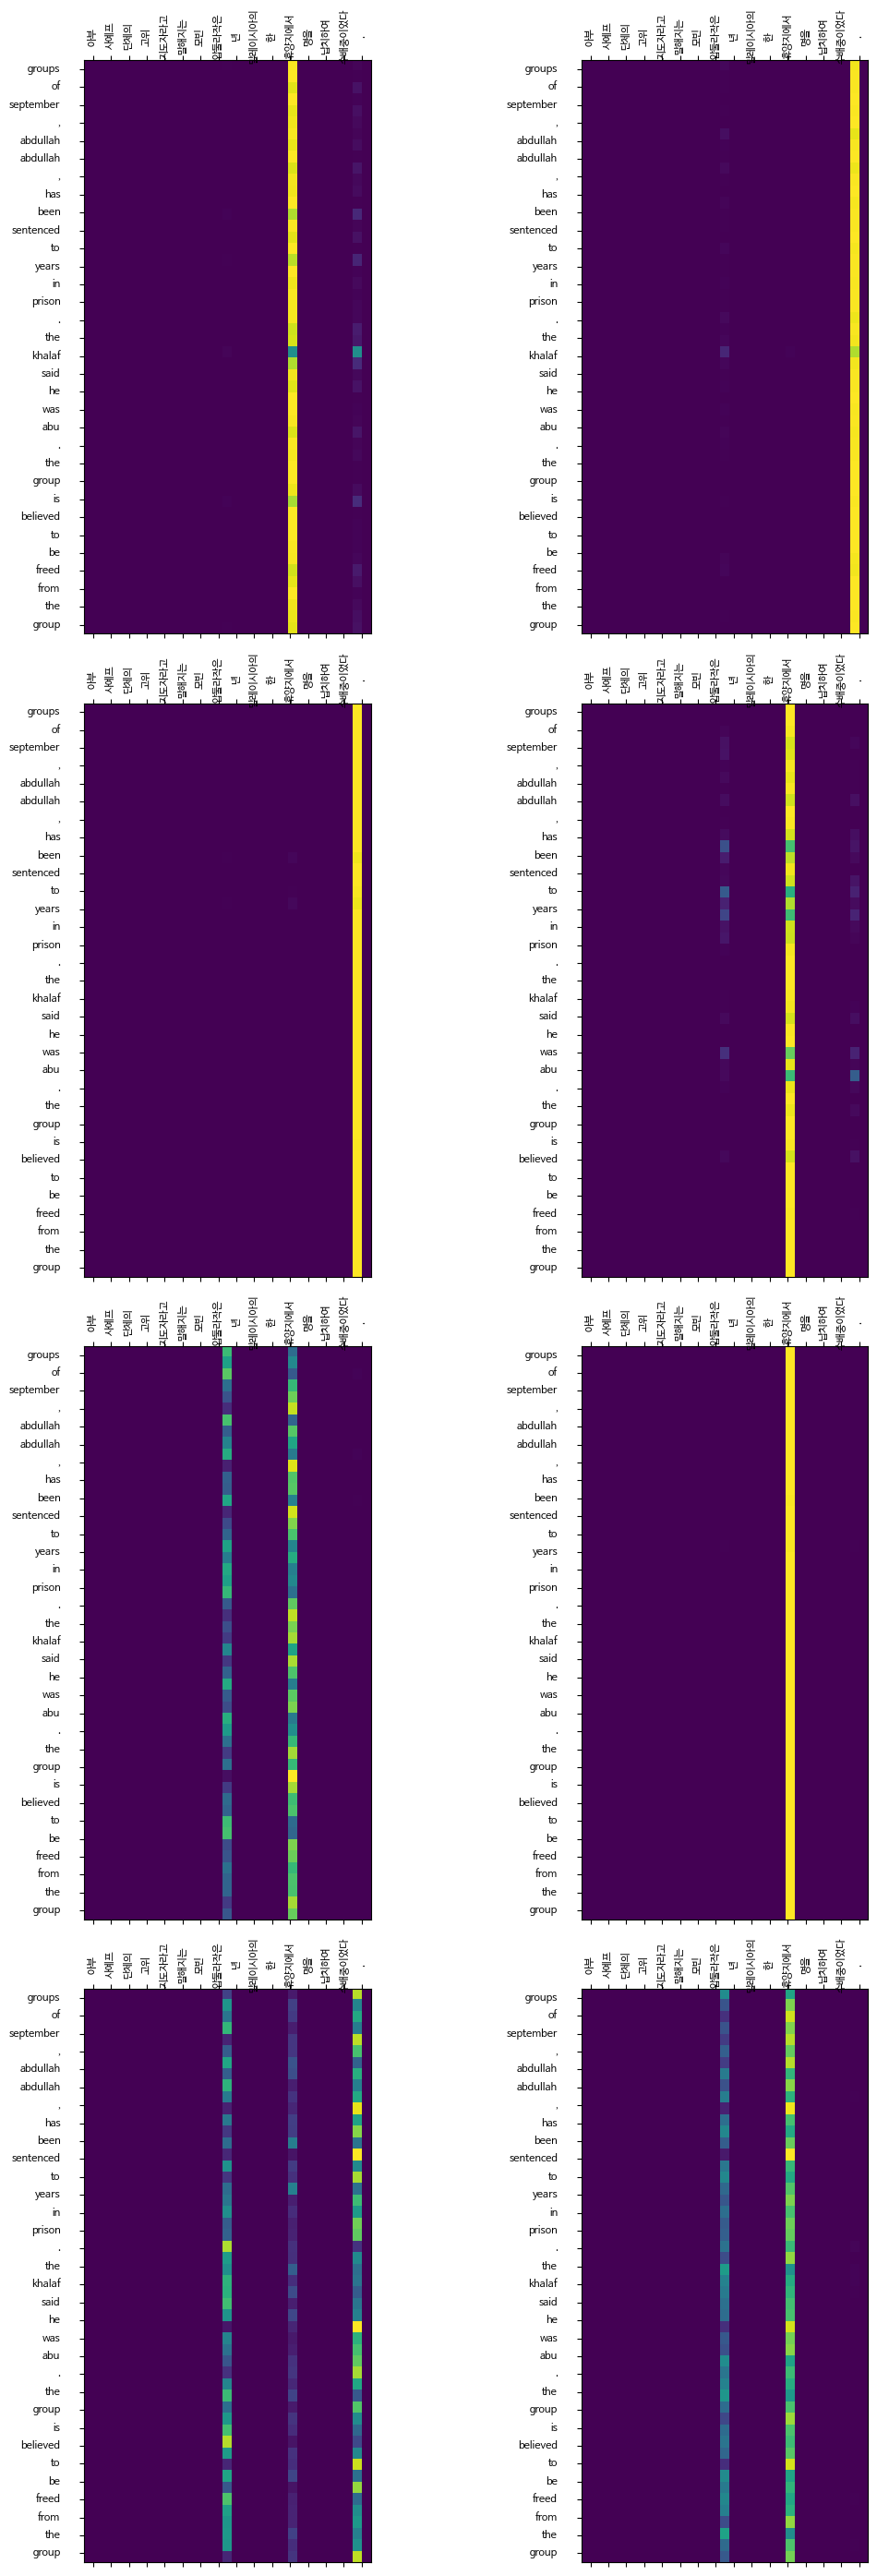

In [16]:
def display_attention(sentence, translation, attention, n_heads=8, n_rows=4, n_cols=2):
    """어텐션 맵을 시각화합니다."""
    assert n_rows * n_cols == n_heads

    font_path = './NanumBarunGothic.ttf'
    font_prop = fm.FontProperties(fname=font_path, size=8)

    fig = plt.figure(figsize=(12, 28))  # x축을 조금 넓혀서 압축 줄임 (10->12)

    # 번역된 문장과 원본 문장을 토큰 단위로 분리
    sentence_tokens = sentence.split()
    translation_tokens = translation.split()

    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)

        # attention shape: (head_idx, tgt_len, src_len)
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        # extent 명시: (-0.5, src_len-0.5, tgt_len-0.5, -0.5)로 ticks와 맞춤
        src_len = len(sentence_tokens)
        tgt_len = len(translation_tokens)
        cax = ax.matshow(_attention, cmap='viridis', extent=[-0.5, src_len - 0.5, tgt_len - 0.5, -0.5])

        # 눈금 위치 설정
        ax.set_xticks(range(src_len))
        ax.set_yticks(range(tgt_len))

        # 라벨 설정: ha/va로 중앙 정렬
        ax.set_xticklabels(sentence_tokens, rotation=90, fontproperties=font_prop, ha='center', va='center')
        ax.set_yticklabels(translation_tokens, fontproperties=font_prop, ha='right', va='center')

        ax.tick_params(labelsize=8, pad=15)  # pad로 텍스트와 tick 간격 미세 조정

    plt.tight_layout()  # subplot 간 여백 자동 조정 (밀림 방지)
    plt.show()

display_attention(src, translation, attention[-1])